## **Deep Learning Week 3: Convolutional Neural Network for Cancer Detection**

This week's project, which is also a **Kaggle-hosted competition**, challenges us to develop a **Convolutional Neural Network (CNN)** algorithm to identify **metastatic cancer** in small image patches taken from **digital pathology scans**. The goal is to differentiate between **non-benign tumors** and healthy tissue, leveraging the labeled training data provided.

### **Background from Kaggle**
As described on Kaggle:
> *"[PCam] packs the clinically relevant task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple of hours and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis..."*

### **Project Scope & Challenges**
At the outset, it is important to note that **several hours of training** is indeed expected due to the size and complexity of the dataset. The dataset consists of **several gigabytes of image data**, requiring careful handling to prevent memory issues.

During my research, I found that some projects opted to **truncate the training dataset** to reduce memory usage and speed up training. To assess the impact of this approach, I conducted experiments using **both a truncated dataset** and the **full dataset**, comparing their **performance and computational efficiency**.






Let's load both test and train directories.  For this project, it is worth mentioning that Train directory is utilized for both test and training splits of the dataset.

In [23]:
train_dir = './train/'
test_dir = './test/'

Setting the local machine os.environment path to the current working directory, and not in this Anaconda application instance to the local

machines anaconda python installation directory.

In [18]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Set the OS path to the current directory
os.environ['PATH'] += os.pathsep + current_dir

Current Directory: c:\Users\christophermoverton\Week3DL_Project


Loading some of the basic modules that were installed for this project.

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from tifffile import imread
import cv2

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import keras
from keras import layers
from keras import initializers

keras.utils.set_random_seed(42)

We want to ensure that gpu support is enabled.  As suggested in lecture, GPU support

considerably decreases the training time spent with CNN.  

In [8]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and initialized!")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")


Num GPUs Available: 1
GPU is available and initialized!


In [9]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__)


Num GPUs Available: 1
2.10.1


### EDA 

Let's load training labels and image ids with the train_df (dataframe) as shown below.

Note:  there are 220,025 images in the train repository with dimension of 96x96 width-height.

So this is approximately 96 (width) x 96 (height) x 3 (rgb color channels) x 225025 (images)= 6,221,491,200 bytes of data! 

That's around 6 gigabytes of data! 

In [10]:
train_df = pd.read_csv('train_labels.csv')
print(train_df.shape)

(220025, 2)


Image id's provide the image names, but this does not include the 'tif' path extension.

In [11]:
print(train_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Configuring a load_image function that integrates both image_dir (image directory) and image iid.

In [12]:
def load_image(iid, image_dir=train_dir):
    path = image_dir + iid + '.tif'
    # print(f'Loading {iid} from {path}')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

Here are some sample images shown below that include training labels.

We might notice that the visual aspects and differences between images with 0 versus 1 labels appear to be complex and nuanced 

using a crude visual examination of the images while looking for textural feature differences.

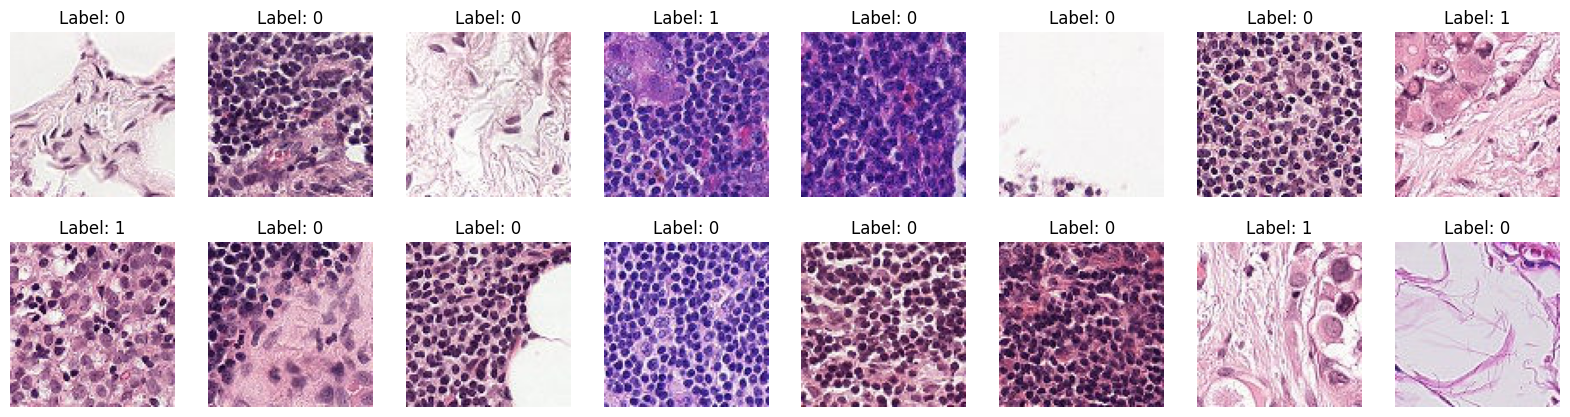

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
for idx, i in enumerate(np.random.choice(train_df['id'], 16)):
    img = load_image(i)
    axes.flat[idx].imshow(img)
    axes.flat[idx].axis('off')
    id = i.split('.')[0]
    l = train_df[train_df.id == id].values[0][1]
    axes.flat[idx].set_title(f'Label: {l}')

There appears to be some slight differences in the distribution of malignant versus benign labeled data.

Thus we may have some added 'benign' fit data, but we also may note that we have a high population of training

data to work with.

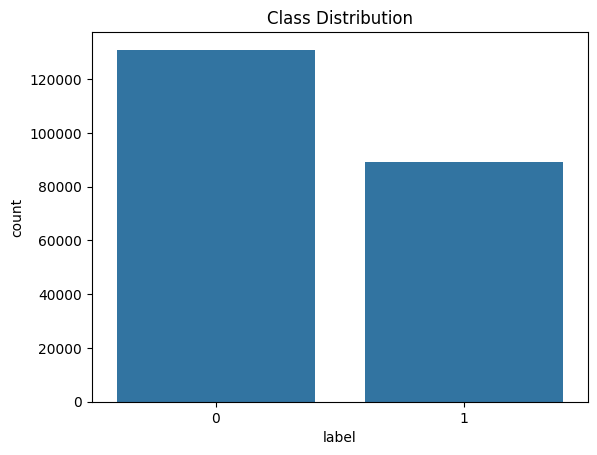

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=train_df['label'])  # Assuming 'label' column contains class info
plt.title("Class Distribution")
plt.show()

Pixel intensity distribution tells us some attributes about this image selected.

A distribution that has peak prominence to the right of say the median at around 125, 

indicates we have a very bright image.  Also the length of the tail from the peak, 

tells us how much contrast we have.  Contrast can be used for edge detection in images.  

Low contrast images make edge detection more subtle and difficult to detect.  This

is important for detecting unique features, for example.

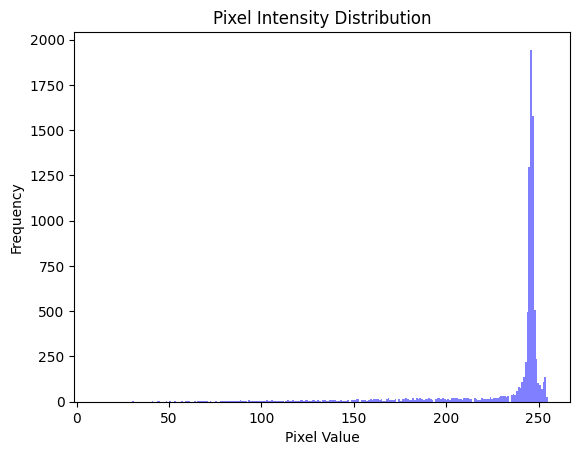

In [13]:
img_path = train_dir+train_df['id'][0]+ '.tif'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
plt.hist(image.ravel(), bins=256, color='blue', alpha=0.5)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

The next image below is the average histogram for light intensity and contrast for 

one hundred images.  This generally tells us that the light intensity peaks for 

bright images (on average), and that the contrast is pretty high on average given

the lengthy tail extents.

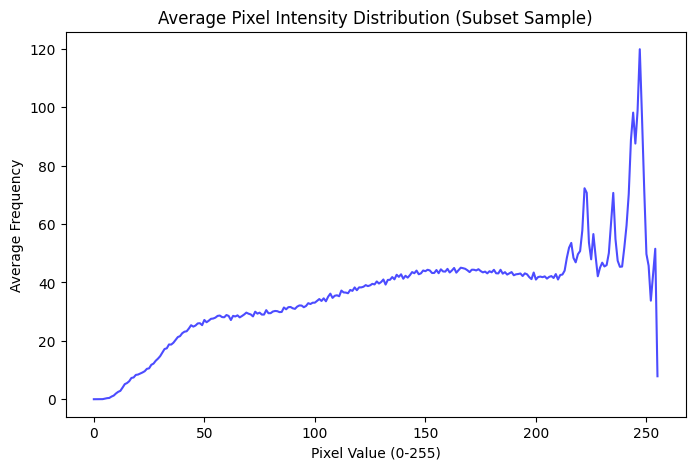

In [14]:
import random
# Define sample size
sample_size = 100  # Adjust based on memory and performance

# Select random images from train_df
sample_images = random.sample(list(train_df['id']), sample_size)

# Initialize histogram storage
hist_sum = np.zeros(256)  # For grayscale images, intensity values range from 0-255

# Process each image in the sample
for img_id in sample_images:
    img_path = train_dir + img_id + '.tif'
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

    if image is not None:  # Ensure image loads correctly
        hist, _ = np.histogram(image.ravel(), bins=256, range=[0,256])  # Compute histogram
        hist_sum += hist  # Sum histograms across images

# Compute the average histogram
average_hist = hist_sum / sample_size  # Normalize by sample size

# Plot the average pixel intensity distribution
plt.figure(figsize=(8,5))
plt.plot(range(256), average_hist, color='blue', alpha=0.7)
plt.title("Average Pixel Intensity Distribution (Subset Sample)")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Average Frequency")
plt.show()

Let's go ahead and work with 10,000 images for training labels '0' and '1' respectively.

We will train this subset first as a means for memory management control.  Otherwise, attempting

to train the entire dataset will result in memory problems most likely (unless having sufficient GPU memory

reserved).

In [15]:
# Define how many images to sample per class
sample_size_per_class = 10000  # Adjust based on memory

# Initialize lists
X_train = []
y_train = []

# Loop through each label
for label in train_df['label'].unique():
    # Get all image IDs for the current label
    label_df = train_df[train_df['label'] == label]

    # Randomly select `sample_size_per_class` images from this label
    selected_ids = np.random.choice(label_df['id'], min(sample_size_per_class, len(label_df)), replace=False)

    # Load images and append to X_train and y_train
    for i in selected_ids:
        img = load_image(i)  # Load image function
        X_train.append(img)
        y_train.append(label)

# Convert to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ y_train shape: {y_train.shape}")

✅ X_train shape: (20000, 96, 96, 3)
✅ y_train shape: (20000,)


#### Let's examine the CNN model structure to be used:

#####  First Convolutional Layer

- Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3))
  - Applies 32 convolution filters of size 3x3 to extract low-level features (edges, textures).
  - Uses ReLU activation to introduce non-linearity and prevent vanishing gradients.
  - Input shape (96,96,3) → 96x96 images with 3 color channels (RGB).

- MaxPooling2D(2,2)
  - Reduces image size by taking the max value in 2x2 regions.
  - This reduces computation and helps detect spatial patterns.

#####  Second Convolutional Block

- Conv2D(64, (3,3), activation='relu')  
  - Increases filters from 32 → 64 to detect higher-level features (shapes, textures).
  
- MaxPooling2D(2,2)  
  - Further reduces spatial dimensions, making the model computationally efficient.

##### Third Convolutional Block

- Conv2D(128, (3,3), activation='relu')  
  - Increases filters to 128 for detecting even more complex patterns.
  
- MaxPooling2D(2,2)  
  - Final downsampling layer before flattening.

##### Flattening & Fully Connected Layers

- Flatten(): Converts the 2D feature maps into a 1D vector for input to the Dense (fully connected) layers.
- Dense(128, activation='relu'):  
  - Fully connected layer with 128 neurons for learning high-level features.
- Dropout(0.5):  
  - Randomly drops 50% of neurons during training to prevent overfitting.  

#####  Output Layer (Binary Classification)

- Dense(1, activation='sigmoid')  
  - A single neuron with a sigmoid activation function for binary classification.
  - Outputs a probability between 0 and 1 (e.g., 0 = Benign, 1 = Malignant).

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN Model for 96x96 images
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display Model Summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)     

Let's go ahead and split the training data now between training and validation sets

In [16]:
from sklearn.model_selection import train_test_split

# Normalize image data
X_train = X_train / 255.0

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"✅ Training set: {X_train.shape}")
print(f"✅ Validation set: {X_val.shape}")


✅ Training set: (16000, 96, 96, 3)
✅ Validation set: (4000, 96, 96, 3)


Fitting the model

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Increase for better results
    batch_size=32
)


Epoch 1/10
500/500 [==============================] - 12s 10ms/step - loss: 0.5217 - accuracy: 0.7494 - val_loss: 0.4770 - val_accuracy: 0.7865
Epoch 2/10
500/500 [==============================] - 4s 7ms/step - loss: 0.4853 - accuracy: 0.7781 - val_loss: 0.4600 - val_accuracy: 0.7875
Epoch 3/10
500/500 [==============================] - 4s 7ms/step - loss: 0.4662 - accuracy: 0.7882 - val_loss: 0.4647 - val_accuracy: 0.7950
Epoch 4/10
500/500 [==============================] - 4s 7ms/step - loss: 0.4518 - accuracy: 0.8024 - val_loss: 0.4482 - val_accuracy: 0.7955
Epoch 5/10
500/500 [==============================] - 4s 7ms/step - loss: 0.4398 - accuracy: 0.8038 - val_loss: 0.4345 - val_accuracy: 0.8020
Epoch 6/10
500/500 [==============================] - 4s 7ms/step - loss: 0.4176 - accuracy: 0.8162 - val_loss: 0.4381 - val_accuracy: 0.8045
Epoch 7/10
500/500 [==============================] - 4s 7ms/step - loss: 0.3907 - accuracy: 0.8273 - val_loss: 0.4344 - val_accuracy: 0.8067
Epoc

We notice in the graph below.  That as training accuracy increases we appear to hit an asymptotic maximum validation accuracy around 81%

for 10 epochs of training.  Thus, we appear to fairly rapidly (within the first five epochs of training) converge on both validation

accuracy maximum and a training loss minimum.  Beyond this we are merely training the model for an overfit with existing data.  

Other related methodologies with more complex CNN models bear out similar accuracy results.  Is this problem relatted to the model, 

or are we not advantaging enough training data to accurately fit our model better for validation data with less overfitting?

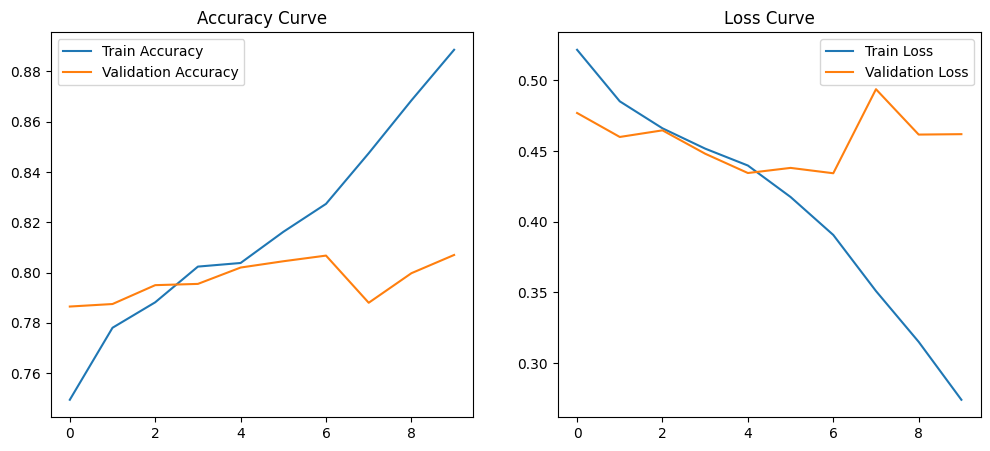

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.show()

plot_history(history)


We will next process the same CNN model with batches of training data, and use most of such training data with a validation

split on the train data using an ImageDataGenerator.  This is a function found in keras.preprocessing.image.  The train and 

validation generators produced from this can be passed to the same CNN model that we used above, but nicely the works training

in smaller batches, so that we don't run out of memory when attempting to fit training data.  We make some small modifications

to train_df changing the 'label' type to str() and adding an extension to 'id', so that this input specified better for the 

ImageDataGenerator functions.  

In [9]:
# Ensure labels are strings
train_df['label'] = train_df['label'].astype(str)


In [11]:
# Append '.tif' to filenames
train_df['id'] = train_df['id'].astype(str) + ".tif"


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with a 20% validation split
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalization + Split

# Load TRAINING images (80%)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,  # Folder where images are stored
    x_col="id",  # Image filenames
    y_col="label",  # Labels
    target_size=(96,96),
    batch_size=32,
    class_mode='binary',
    subset="training"  # Uses 80% for training
)

# Load VALIDATION images (20%)
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="id",
    y_col="label",
    target_size=(96,96),
    batch_size=32,
    class_mode='binary',
    subset="validation"  # Uses 20% for validation
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Verifying that the training samples and validation samples are loaded in the image genertor.

In [13]:
# Check the number of images detected
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


Training samples: 176020
Validation samples: 44005


No changes for the same model as before

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model (using Adam optimizer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

Now we fit train_generator data and compare accuracy of fit for validation data with val_generator.

In [15]:
# Train the model using GPU
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Increase for better performance
    batch_size=32,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/10
5501/5501 [==============================] - 783s 141ms/step - loss: 0.4231 - accuracy: 0.8121 - val_loss: 0.3267 - val_accuracy: 0.8646
Epoch 2/10
5501/5501 [==============================] - 736s 134ms/step - loss: 0.3200 - accuracy: 0.8665 - val_loss: 0.2804 - val_accuracy: 0.8856
Epoch 3/10
5501/5501 [==============================] - 667s 121ms/step - loss: 0.2815 - accuracy: 0.8856 - val_loss: 0.2527 - val_accuracy: 0.8975
Epoch 4/10
5501/5501 [==============================] - 662s 120ms/step - loss: 0.2556 - accuracy: 0.8973 - val_loss: 0.2451 - val_accuracy: 0.9038
Epoch 5/10
5501/5501 [==============================] - 690s 125ms/step - loss: 0.2351 - accuracy: 0.9067 - val_loss: 0.2488 - val_accuracy: 0.9035
Epoch 6/10
5501/5501 [==============================] - 679s 123ms/step - loss: 0.2216 - accuracy: 0.9130 - val_loss: 0.2330 - val_accuracy: 0.9082
Epoch 7/10
5501/5501 [==============================] - 686s 125ms/step - loss: 0.2055 - accuracy: 0.9195 - val_

As it turns out we have sharp increase in validation accuracy with less overfitting!

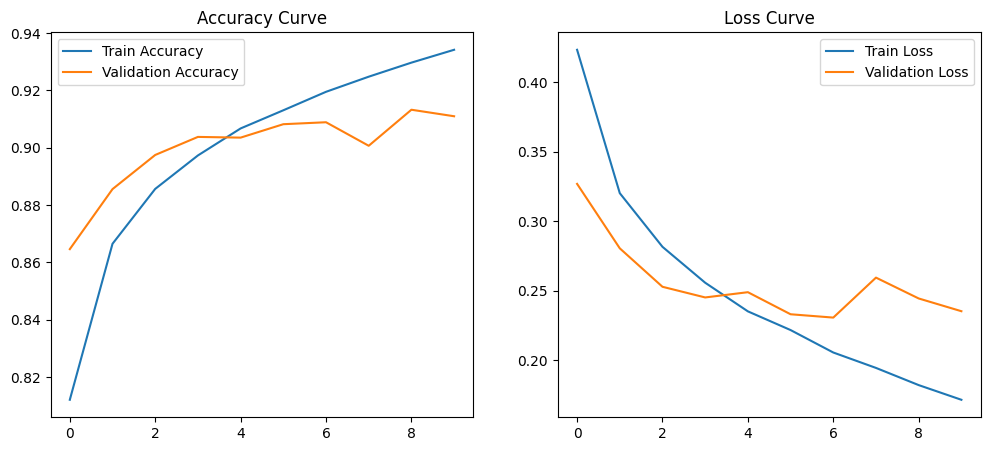

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.show()

plot_history(history)


We can save the model for reuse if we like.

In [17]:
model.save('cancer_detection_cnn_96x96.h5')


Can we tune a model with hyper parameters for increased performance?  

Let's try single epoch tests with 10 different trials and randomized

parameter settings to see if we can produce a best model.  For the purposes of this

research, I've limited the test trials to single epoch training because each trial

takes approximately 12-14 minutes completion time.  This is around 120-140 minutes 

of machine time with GPU support, so it is cumbersome with the large batched dataset

that we are using.  The goal of this isn't to prove that hyper parameter trials can 

produce a more optimal model, but that we can do this.

In [20]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

# Define a function to build the model for tuning
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('filters1', 32, 128, step=32), (3,3), activation='relu', input_shape=(96,96,3)),
        MaxPooling2D(2,2),

        Conv2D(hp.Int('filters2', 64, 256, step=64), (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'),
        Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),  # Dropout tuning
        Dense(1, activation='sigmoid')
    ])

    # Tune learning rate
    optimizer = Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different configurations to try
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='cancer_detection'
)

# Run hyperparameter search
tuner.search(train_generator, validation_data=val_generator, epochs=1)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
Filters1: {best_hps.get('filters1')}
Filters2: {best_hps.get('filters2')}
Dense Units: {best_hps.get('dense_units')}
Dropout: {best_hps.get('dropout')}
Learning Rate: {best_hps.get('learning_rate')}
""")


Trial 10 Complete [00h 11m 11s]
val_accuracy: 0.8334734439849854

Best val_accuracy So Far: 0.8471537232398987
Total elapsed time: 01h 55m 53s

Best hyperparameters:
Filters1: 96
Filters2: 128
Dense Units: 384
Dropout: 0.30000000000000004
Learning Rate: 0.0001



Let's take the "optimized" hyperparameters and apply this to the model.

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define optimized CNN model
model = Sequential([
    Conv2D(96, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(384, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with the optimized learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 96)        2688      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 128)       110720    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_2 (Dense)             (None, 384)              

In [22]:
history = model.fit(
    train_generator,  # Training data
    validation_data=val_generator,  # Validation data
    epochs=10,  # Increase if needed
    batch_size=32,  # Default batch size
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/10
5501/5501 [==============================] - 707s 128ms/step - loss: 0.4362 - accuracy: 0.8028 - val_loss: 0.3838 - val_accuracy: 0.8325
Epoch 2/10
5501/5501 [==============================] - 671s 122ms/step - loss: 0.3519 - accuracy: 0.8484 - val_loss: 0.3236 - val_accuracy: 0.8639
Epoch 3/10
5501/5501 [==============================] - 667s 121ms/step - loss: 0.2964 - accuracy: 0.8753 - val_loss: 0.2965 - val_accuracy: 0.8756
Epoch 4/10
5501/5501 [==============================] - 649s 118ms/step - loss: 0.2518 - accuracy: 0.8963 - val_loss: 0.2729 - val_accuracy: 0.8891
Epoch 5/10
5501/5501 [==============================] - 625s 114ms/step - loss: 0.2106 - accuracy: 0.9159 - val_loss: 0.2841 - val_accuracy: 0.8806
Epoch 6/10
5501/5501 [==============================] - 631s 115ms/step - loss: 0.1700 - accuracy: 0.9343 - val_loss: 0.3068 - val_accuracy: 0.8821
Epoch 7/10
5501/5501 [==============================] - 656s 119ms/step - loss: 0.1330 - accuracy: 0.9501 - val_

The plot below demonstrates that they hyper-parameter optimized model (for a single epoch of training) is not optimal compared to 

our previous model over the series of 10 epochs of training.  As it turns out we have substantially more training parameters on the

"optimized" model, but perhaps, as demonstrated by graph results below, overfitting was occurring early because we attempted to 

do enhanced higher resolution feature extraction too early in the model layers which would consequently lead to rapid model overfitting!

Despite this validation accuracy performed between our very first model, and the previous model which scored the highest.

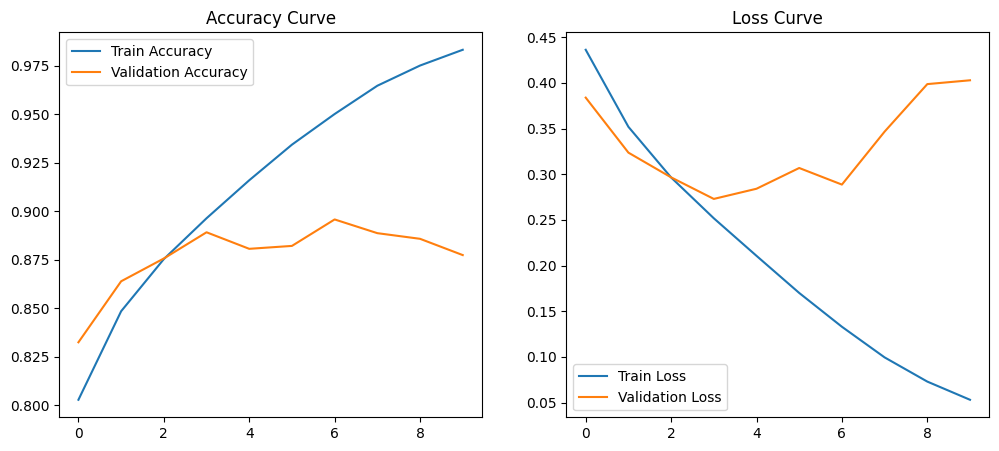

In [23]:


def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.show()

plot_history(history)


For the last part of this project, let's go ahead and use the best fit model for competition submission

We will need to compile a test_df (dataframe), so that we can do predict batch processsing for the competition.

Next, after compiling predictions, we will conform the test_df with prediction results, so that it matches 

competition submission requirements, and finally we save this to a .csv file where can upload to kaggle our

.csv test_prediction file.

In [21]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('cancer_detection_cnn_96x96.h5')

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [27]:
import os
import pandas as pd

# Define test directory
test_dir = "test"

# List all .tif files in the directory
test_files = [f for f in os.listdir(test_dir) if f.endswith('.tif')]

# Create a DataFrame with full paths
test_df = pd.DataFrame({'filename': test_files})

# Display first few rows
print(test_df.head())


                                       filename
0  00006537328c33e284c973d7b39d340809f7271b.tif
1  0000ec92553fda4ce39889f9226ace43cae3364e.tif
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3  000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4  000270442cc15af719583a8172c87cd2bd9c7746.tif


In [ ]:
# Define ImageDataGenerator (Rescale pixels)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test images using flow_from_dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,  # Path to test images
    x_col="filename",  # Column containing image filenames
    target_size=(96,96),  # Resize to match model input
    batch_size=32,
    class_mode=None,  # No labels available
    shuffle=False  # Maintain file order
)

print(f"✅ Found {len(test_generator.filenames)} test images")


Found 57458 validated image filenames.
✅ Found 57458 test images


In [ ]:
# Predict on test images
predictions = model.predict(test_generator, verbose=1)

# Convert probabilities to binary class labels (0 = benign, 1 = malignant)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to DataFrame
test_df['Prediction'] = predicted_labels

# Display first few results
print(test_df.head())


1796/1796 [==============================] - 208s 113ms/step
                                       filename  Prediction
0  00006537328c33e284c973d7b39d340809f7271b.tif           1
1  0000ec92553fda4ce39889f9226ace43cae3364e.tif           1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif           1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6.tif           0
4  000270442cc15af719583a8172c87cd2bd9c7746.tif           0


In [32]:
# Remove the '.tif' extension and rename the column to 'id'
test_df['id'] = test_df['filename'].str.replace('.tif', '', regex=False)

# Rename 'Prediction' to 'label'
test_df = test_df.rename(columns={'Prediction': 'label'})

# Drop the old 'Filename' column
test_df = test_df[['id', 'label']]

test_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [33]:
test_df.to_csv("test_predictions.csv", index=False)
print("✅ Predictions saved to test_predictions.csv")


✅ Predictions saved to test_predictions.csv


### Conclusions and Discusion

####  Model type Conclusions
| **Model** | **Max Training Accuracy** | **Max Validation Accuracy** | **Observations** |
|-----------|-----------------|-----------------|-----------------|
| **Model 1 (20K Sample)** | **88.8%** | **80.7%** | Limited data led to overfitting |
| **Model 2 (Full Dataset, Batched)** | **93.4%** | **91.1%** | Best balance of performance and generalization |
| **Model 3 (Hyperparameter Tuned)** | **98.3%** | **87.7%** | Overfitting increased, validation performance dropped |

We can see that using a limited dataset, while solving out-of-memory problems for non-batched model fittting, showed problems

in data diversity capture.  This means likely there could be forms of malignant and benign cancer that were simply under-captured 

in the basic CNN training model.  On the other hand, using batched training for a basic CNN model with excellent initial starting

parameter choices, produced a model that generalized well to the dataset for validation accuracy, and significantly reduced 

overfitting performance gaps.  Hyper-parameter tuning shows some potential, but unfortunately, because of time constraint limitations

imposed in the testing procedure, we couldn't really see the full expression of performance over a series of epochs per trial 

for parameter optimization.  These limitations consequently reduced our testing ability in confirming overfits, and performance generalization

of the tune 'optimized' model.  A remedy to the hyper-parameter testing problem would simply be to increase the number of epochs involved

in researching best fit models.  Considering that 10 epochs of batched training,  however, amounts to well over an hour of training for each

of ten tests, ensures, however, that parameter tuning could take well in excess of 10 hours even with GPU dedicated time.